# SVM model to detect introgression: success with binary classification, less so (so far) with regression

In [1]:
import msprime
import argparse
from random import sample
import numpy as np
import time
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt

Here we can make lists of values for migration rates, timing, etc. so that we have independent samples. We choose to run 2000 simulations - 1500 for training, 500 for testing. This is a small number.

In [16]:
samplenum = 2000 # how many simulation samples
# make list of migration rates
mig_rate = np.append(np.random.gamma(shape = 1,  # make half of the rates positive and the other half zero
                                     scale=.01,
                                     size = int(samplenum/2.)),
                     [0]*(int(samplenum/2.)))
np.random.shuffle(mig_rate)

# select window width 
win_width = [.05]*samplenum # if varying: np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*samplenum # if varying: np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
#num_reps_list = [10000]*samplenum # if varying: (5000+np.random.randint(1,15000,1000000))*2

Now we can run simulations. Note that for the sake of starting simple, the *only* parameter changing between simulations is the migration rate.

In [17]:
t0 = time.time() # start the clock

genotypes= ['0000','1000','1100','1110','1111','1011','1010','1101',
 '0111','0011','0010','0001','0100','0110','1001'] # this is for getting count numbers for the feature vector

counts = np.empty(shape = [0,len(genotypes)],dtype=int) # this will be filled with our training/testing instances

for sample in range(samplenum):
    length = 10000
    Ne = 1000000
    mutation_rate = 7e-8
    num_replicates = 1
    recombination_rate = 1e-8
    
    # Four tips of the tree
    population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]
    
    # No migration initially
    migration_matrix = [[0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],]
    
    # Define demographic events for msprime
    demographic_events = [msprime.MigrationRateChange(time=0,
                                                      rate=0),
                         msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,
                                                     rate=mig_rate[sample],
                                                     matrix_index=[0,2]),
                         msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,
                                                     rate=0),
                         msprime.MassMigration(destination=1,
                                               source=0,
                                               time=1.0*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=2,
                                               time=1.2*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=3,
                                               time=1.5*4*Ne,
                                               proportion=1)
                         ]
    
    # Our msprime simulation:
    simulation = msprime.simulate(length=length,
                     Ne=Ne,
                     mutation_rate=mutation_rate,
                     num_replicates=num_replicates,
                     recombination_rate=recombination_rate,
                     population_configurations=population_configurations,
                     migration_matrix = migration_matrix,         
                     demographic_events=demographic_events)
    
    # Access the genotype matrix and format the elements to match our 'genotypes' list defined above
    geno = simulation.next().genotype_matrix()
    geno= geno.astype(str)
    geno_conv = [''.join(i) for i in geno]
    
    # Tally the frequency of each genotype
    tallies = np.empty(shape = [0,0])
    for genotype in np.unique(genotypes):
        tally = 0
        for instance in geno_conv:
            tally = tally + int(instance == genotype)
        if tally:
            tallies = np.append(tallies,tally)
        else:
            tallies = np.append(tallies,0)
            
    # Save our feature vector into a matrix of instances for our model
    counts = np.vstack([counts, tallies.astype(int)])
    
t1 = time.time() # stop the clock

print("Total time: " + str(round(t1-t0,3)) + " seconds.")

Total time: 382.43 seconds.


Now we normalize the data. This isn't essential for some models (e.g. random forests), but SVMs are super scale-dependent.

In [18]:
norm=preprocessing.Normalizer(copy=False,norm='l1')
trans_norm = norm.transform(counts)

Before we fit our binary classification model, we want to get our "labels" data set. This means converting our migration rates from continuous values to "1" if migration was present at all and "0" if no migration occurred.

In [19]:
int_mig_rate=(mig_rate > 0).astype(int)

Now we can fit a classification model. Here, I'm using an SVM. Plenty of other options exist for this, including regression and decision trees.

In [25]:
from sklearn import svm
X = trans_norm[0:1500]
y = int_mig_rate[0:1500]
clf = svm.SVC(C=10)
clf.fit(X, y)  

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Now we just have to prepare our training data set, sorting it so that any wrong predictions by the model are more obvious.

In [26]:
testset = np.empty(shape=[0,16])
for i in range(1500,2000):
    testset=np.vstack([testset,np.append(mig_rate[i],trans_norm[i])])

In [27]:
testset[:,0] = (testset[:,0] > 0).astype(int)
sorted_test= testset[testset[:,0].argsort()]

### Real answers:

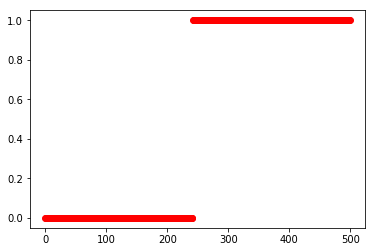

In [28]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

### Model predictions:

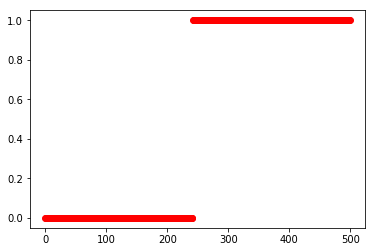

In [29]:
plt.plot(clf.predict(sorted_test[:,1:16]),'ro')
plt.show()

So our classifier is great, under very simple conditions, at identifying whether migration has occurred. Nice.

Now let's try a regression: can we tell how much migration has occurred?

In [58]:
X = trans_norm[0:1500]
y = mig_rate[0:1500] # notice this is no longer made of integer values
regr = svm.SVR(C=.001,epsilon=0.01) # now using a regression model
regr.fit(X, y) 

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Prepare test data:

In [31]:
testset = np.empty(shape=[0,16])
for i in range(1500,2000):
    testset=np.vstack([testset,np.append(mig_rate[i],trans_norm[i])])
sorted_test= testset[testset[:,0].argsort()]

### Real answers:

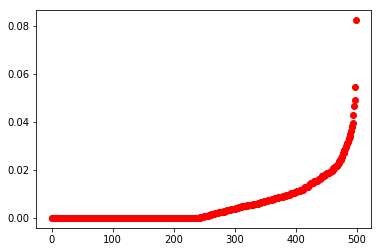

In [32]:
import matplotlib.pyplot as plt
plt.plot(sorted_test[:,0], 'ro')
plt.show()

### Model predictions:

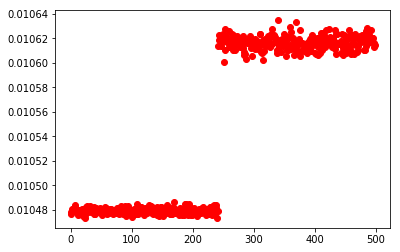

In [59]:
plt.plot(regr.predict(sorted_test[:,1:16]),'ro')
plt.show()

So our model seems to be really good separating "no migration" from "some migration," but we haven't really figured out the regression thing yet.